# Import

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os
import time
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re
import random

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import LocalCluster, Client

sys.path.insert(0, 'tools/')

from tools import * 

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

from sklearn import neighbors
from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

# Read files

In [4]:
%%time

X_train = pd.read_csv('dades/processed/training_data.csv', index_col='index')
X_train = X_train.reset_index(drop=True)
y_train = X_train.ctx0.copy()

X_val = pd.read_csv('dades/processed/validation_data.csv', index_col='index')
X_val = X_val.reset_index(drop=True)
y_val = X_val.ctx0.copy()

X_test = pd.read_csv('dades/processed/testing_data.csv', index_col='index')
X_test = X_test.reset_index(drop=True)
y_test = X_test.ctx0.copy()


CPU times: user 34.2 s, sys: 3.3 s, total: 37.5 s
Wall time: 37.5 s


In [5]:
cat_y_train = ((y_train.copy()*100)/5).round().astype(int)
cat_y_val = ((y_val.copy()*100)/5).round().astype(int)
cat_y_test = ((y_test.copy()*100)/5).round().astype(int)

In [6]:
years = X_train.year.unique().tolist()
years

[2019, 2022]

In [7]:
months = X_train.month.unique().tolist()
months

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

# Run pipeline

In [11]:
X_train.columns

Index(['station_id', 'year', 'month', 'dayofweek', 'day', 'dayofyear', 'hour',
       'capacity', 'ctx0', 'ctx1', 'ctx2', 'ctx3', 'ctx4', 'festius',
       'festius_sun', 'festius_sun_sat', 'weekend', 'VALOR_TM_D5',
       'VALOR_TX_D5', 'VALOR_TN_D5', 'VALOR_HRM_D5', 'VALOR_PPT_D5',
       'VALOR_PM_D5', 'VALOR_RS24h_D5', 'VALOR_VVM10_D5', 'VALOR_DVM10_D5',
       'VALOR_VVX10_D5', 'VALOR_DVVX10_D5', 'VALOR_HRX_D5', 'VALOR_HRN_D5',
       'VALOR_PX_D5', 'VALOR_PN_D5', 'VALOR_TM_X2', 'VALOR_TX_X2',
       'VALOR_TN_X2', 'VALOR_HRM_X2', 'VALOR_HRX_X2', 'VALOR_HRN_X2',
       'VALOR_TM_X4', 'VALOR_TX_X4', 'VALOR_TN_X4', 'VALOR_HRM_X4',
       'VALOR_PPT_X4', 'VALOR_PM_X4', 'VALOR_RS24h_X4', 'VALOR_VVM10_X4',
       'VALOR_DVM10_X4', 'VALOR_VVX10_X4', 'VALOR_DVVX10_X4', 'VALOR_HRX_X4',
       'VALOR_HRN_X4', 'VALOR_PX_X4', 'VALOR_PN_X4', 'VALOR_TM_X8',
       'VALOR_TX_X8', 'VALOR_TN_X8', 'VALOR_HRM_X8', 'VALOR_PPT_X8',
       'VALOR_PM_X8', 'VALOR_RS24h_X8', 'VALOR_VVM10_X8', 'VALOR_DVM1

In [12]:
columns = X_train.columns[['VALOR' not in i for i in X_train.columns]].to_list()

In [13]:
%%time 

correlations = np.abs(
    X_train[columns].corr(method='pearson').ctx0
).sort_values(ascending=False)

correlations.to_dict()

CPU times: user 6.74 s, sys: 199 ms, total: 6.94 s
Wall time: 6.94 s


{'ctx0': 1.0,
 'ctx1': 0.922782456240714,
 'ctx1_ctx2_mean': 0.8885207453250363,
 'ctx1_ctx2_ctx3_mean': 0.8555430769022581,
 'ctx1_ctx2_ctx3_ctx4_mean': 0.8239822725983219,
 'ctx2': 0.819636295322785,
 'ctx3': 0.7269660619171394,
 'ctx4': 0.6433542864387456,
 'ctx1_ctx2_ctx3_ctx4_std': 0.1788328563180239,
 'ctx1_ctx2_ctx3_std': 0.1624569609205879,
 'ctx1_ctx2_std': 0.13614849127354808,
 'station_id': 0.058572666456470864,
 'month': 0.04797209212986377,
 'dayofyear': 0.04658815108186215,
 'festius': 0.026205363407866854,
 'festius_sun': 0.02428332213799446,
 'hour': 0.02221610656684412,
 'weekend': 0.020687138715983638,
 'festius_sun_sat': 0.020408291886535937,
 'dayofweek': 0.01682990398446328,
 'day': 0.011988856445992522,
 'year': 0.011565763518756121,
 'capacity': 0.009925167482363198}

In [14]:
columns_ctx = X_train.columns[['ctx' in i for i in X_train.columns]].to_list()
columns_ctx.remove('ctx0')

In [15]:
columns_meteo = ['VALOR_TN_X4','VALOR_TM_X4', 'VALOR_TX_X4', 'VALOR_PPT_X4']

In [16]:
class Config:
    num_attribs0 = ['capacity'] + columns_ctx + columns_meteo
    cat_attribs0 = ['month', 'dayofyear', 'hour', 'dayofweek', 'day'] 
    cat_attribs1 = ['']
    gen_attribs0 = ['station_id', 'festius_sun', 'weekend']
    target_col = ['ctx0']
    
    seed=42
    
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    

In [17]:
config=Config()
seed_everything(config.seed)

In [18]:

def build_preprocessor(config):
    num_attribs0 = config.num_attribs0
    cat_attribs0 = config.cat_attribs0
    cat_attribs1 = config.cat_attribs1
    gen_attribs0 = config.gen_attribs0

    num_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ('std_scaler', (StandardScaler())),
    ])

    categorical_transformer0 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('ordinal_encoder', (OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))),
    ])
    
    categorical_transformer1 = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
        ('one_hot_encoder', (OneHotEncoder(handle_unknown='ignore'))),
    ])
    
    generic_transformer0 = Pipeline([
        ("imputer", SimpleImputer(strategy="constant",fill_value=0)),
    ])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num0", num_transformer0, num_attribs0),
            ("gen1", generic_transformer0, gen_attribs0),
            ("cat0", categorical_transformer0, cat_attribs0),
#             ("cat1", categorical_transformer1, cat_attribs1),
        ],
        remainder="drop"
    )
    
    return preprocessor

In [19]:
%%time 

full_pipeline = build_preprocessor(config)

CPU times: user 34 µs, sys: 4 µs, total: 38 µs
Wall time: 39.6 µs


In [20]:
full_pipeline.fit(X_train)

ColumnTransformer(transformers=[('num0',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['capacity', 'ctx1', 'ctx2', 'ctx3', 'ctx4',
                                  'ctx1_ctx2_mean', 'ctx1_ctx2_std',
                                  'ctx1_ctx2_ctx3_mean', 'ctx1_ctx2_ctx3_std',
                                  'ctx1_ctx2_ctx3_ctx4_mean',
                                  'ctx1_ctx2_ctx3_ctx4_std', 'VALOR_TN_X4',
                                  'VALOR_TM_X4', 'VALOR_TX_X4',
                                  'VALOR_PPT_X4']),
                                ('gen1',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'))]),
                                 ['station_id', 'festius_sun', 'weekend']),
                                ('cat0',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan))]),
                                 ['month', 'dayofyear', 'hour', 'dayofweek',
                                  'day'])])

In [21]:
def apply_pipeline(pipline, X, y, args=None, show=True):
    assert X.shape[0] == y.shape[0]
    
    X_prepared = full_pipeline.transform(X)
    
    if show:
        print("X", X.shape, 
              "X_prepared:", X_prepared.shape,
              "y: ", y.shape
             )
        
    if args:
        return X_prepared, y, *args
    else:
        return X_prepared, y

In [22]:
def prepare_splits(
    pipeline,
    data_train,
    data_val,
    data_test,
    years, 
    months, 
    show=True
):
    if show:
        print("train")
    
    train_cond = (data_train[0].year.isin(years) & data_train[0].month.isin(months))
    Xtr, ytr = apply_pipeline(
        pipeline,
        data_train[0][train_cond], 
        data_train[1][train_cond],
        show=show
    )

    if show:
        print("val")
    
    val_cond = (data_val[0].year.isin(years) & data_val[0].month.isin(months))
    Xva, yva = apply_pipeline(
        pipeline, 
        data_val[0][val_cond], 
        data_val[1][val_cond],
        show=show
    )

    if show:
        print("test")
    
    test_cond = (data_test[0].year.isin([2023]) & data_test[0].month.isin([3]))
    Xte, yte = apply_pipeline(
        pipeline, 
        data_test[0][test_cond],
        data_test[1][test_cond],
        show=show
    )
    
    return Xtr, ytr, Xva, yva, Xte, yte

In [23]:
def test_model_train_val_test(
    model,
    data_train,
    data_val,
    data_test,
    skip_cv=False,
    show=False,
    error_score='raise'
):
    if skip_cv==False:
        cross_val_evaluation(
            model, 
            data_train[0], 
            data_train[1], 
            'model test', 
            n_jobs=5,
            error_score=error_score
        )
    
    model.fit(data_train[0], data_train[1])
    
    return {
        'train':test_model(model, data_train[0], data_train[1], show=show)[['mse_t','rmse_t','mae_t','r2_t']],
        'test':test_model(model, data_val[0], data_val[1], data_test[0], data_test[1], show=show)[['mse_t','rmse_t','mae_t','r2_t', 'mse_v','rmse_v','mae_v','r2_v']]
    }


In [24]:
def do_test_per_month(
    model, 
    modelargs,
    data_train,
    data_val,
    data_test,
    years,
    months
):
    result = {}
    with tqdm(range (len(years)*len(months)), unit="months", mininterval=0, disable=False) as bar:
        for index in bar:
            month = months[(index%len(months))]
            year = years[int(index>=len(months))]
            bar.set_description(f"Month {year}-{month}")

            Xtr, ytr, Xva, yva, Xte, yte = prepare_splits(
                full_pipeline,
                data_train,
                data_val,
                data_test,
                [year], [month], False)
            
            # define model 
            m = model(**modelargs)

            result[index] = test_model_train_val_test(
                m,
                (Xtr, ytr),
                (Xva, yva),
                (Xte, yte),
                skip_cv=True,
                show=False,
                error_score='raise'
            )
                
    result=pd.DataFrame(result)
    aux=pd.DataFrame(result.T.unstack().reset_index()[0].to_dict()).T
    aux['type']=pd.DataFrame(result.T.unstack().reset_index().level_0)
    aux['order']=pd.DataFrame(result.T.unstack().reset_index().level_1)
    aux = pd.DataFrame(aux.set_index(['type', 'order']).unstack(['type']).reindex()).reset_index()
    aux.columns = ['_'.join(col) for col in aux.columns.values]
    
    return aux

In [25]:
def do_test_per_month_combos(
    model, 
    modelargs,
    data_train,
    data_val,
    data_test,
    years,
    months
):
    result = {}
    with tqdm(range (len(years)*len(months)), unit="months", mininterval=0, disable=False) as bar:
        for index in bar:
            month_combo = months[(index%len(months))]
            year = years[int(index>=len(months))]
            bar.set_description(f"Month {year}-{month_combo}")

            Xtr, ytr, Xva, yva, Xte, yte = prepare_splits(
                full_pipeline,
                data_train,
                data_val,
                data_test,
                [year], month_combo, False)
            
            # define model 
            m = model(**modelargs)

            result[index] = test_model_train_val_test(
                m,
                (Xtr, ytr),
                (Xva, yva),
                (Xte, yte),
                skip_cv=True,
                show=False,
                error_score='raise'
            )
            
    result=pd.DataFrame(result)
    aux=pd.DataFrame(result.T.unstack().reset_index()[0].to_dict()).T
    aux['type']=pd.DataFrame(result.T.unstack().reset_index().level_0)
    aux['order']=pd.DataFrame(result.T.unstack().reset_index().level_1)
    aux = pd.DataFrame(aux.set_index(['type', 'order']).unstack(['type']).reindex()).reset_index()
    aux.columns = ['_'.join(col) for col in aux.columns.values]
    
    return aux

In [26]:
[months.remove(x) for x in [6,7,8,9,10]]

[None, None, None, None]

In [27]:
years, months

([2019, 2022], [1, 2, 3, 4, 5, 10, 11, 12])

In [28]:
# Take data of 2022 

X_train_prepared, y_train_prepared, X_val_prepared, y_val_prepared, X_test_prepared, y_test_prepared = prepare_splits(
    full_pipeline,
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test),
    [2022], months, True)


train
X (2357330, 74) X_prepared: (2357330, 23) y:  (2357330,)
val
X (586724, 74) X_prepared: (586724, 23) y:  (586724,)
test
X (359126, 74) X_prepared: (359126, 23) y:  (359126,)


In [29]:
import gc

gc.collect()

72

# Prediction

a) Regresión lineal: relación lineal entre las variables de entrada y la variable de salida. 

b) Regresión Redes Neuronales (RNN -redes neuronales recurrentes-): pueden capturar relaciones no lineales entre las variables de entrada y salida.

## LinearRegression

In [54]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [55]:
lin_reg = LinearRegression(n_jobs=5)

In [56]:
ridge_reg = Ridge(alpha=.3, random_state=config.seed)

In [57]:
lasso_reg = Lasso(alpha=0.01, random_state=config.seed)

In [63]:
# Elastic net regression is a linear regression model
# reduce overfitting
# and select relevant features
# uses a penalty term to shrink the coefficients of the predictors.
# combination of the l1-norm (absolute value) and the l2-norm (square) of the coefficients

# The main difference between elastic net and lasso or ridge is that elastic net has an additional parameter called lambda, 
# which controls the balance between the l1-norm and the l2-norm penalties. When lambda is zero, elastic net is equivalent to lasso.
# When lambda is one, elastic net is equivalent to ridge. When lambda is between zero and one, elastic net is a compromise between 
# lasso and ridge. This allows elastic net to adapt to different situations and data sets.

elasticNet_reg = ElasticNet(alpha=0.01, l1_ratio=0.3, random_state=config.seed) 

### Train and test, validate model

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    5.3s remaining:    8.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.4s finished



  model test
Scores: [-0.11544144 -0.11536417 -0.11512653 -0.11581943 -0.11524325]
Mean: -0.11539896385795709
Standard deviation: 0.00023591090414300668

Training time: 0.054 s
----- EVALUATION ON VAL SET ------
MSE: 0.013316624118569645
RMSE 0.11539767813335607
MAE: 0.07694603435618329
R^2:  0.8052126376530713



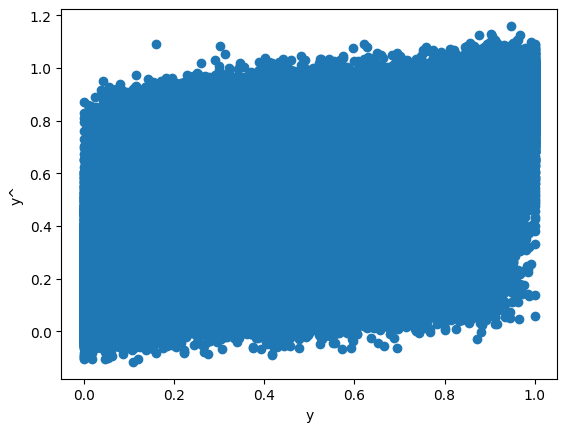


Training time: 0.015 s
----- EVALUATION ON VAL SET ------
MSE: 0.009435906435287354
RMSE 0.09713859395362563
MAE: 0.06328191226306983
R^2:  0.8556368971637807



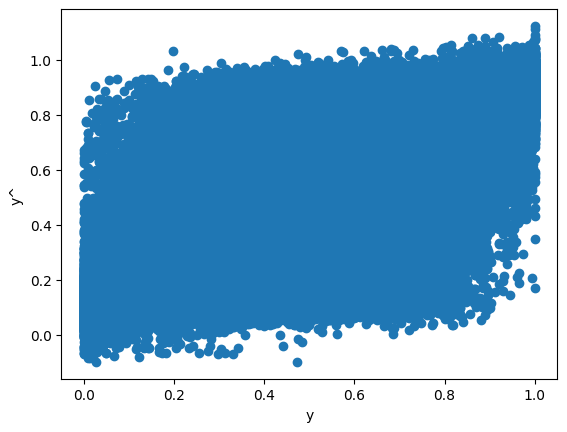


Testing time: 0.009 s
----- EVALUATION ON VAL SET ------
MSE: 0.01401534427923937
RMSE 0.11838641931927568
MAE: 0.07982806789535438
R^2:  0.8083783687144137



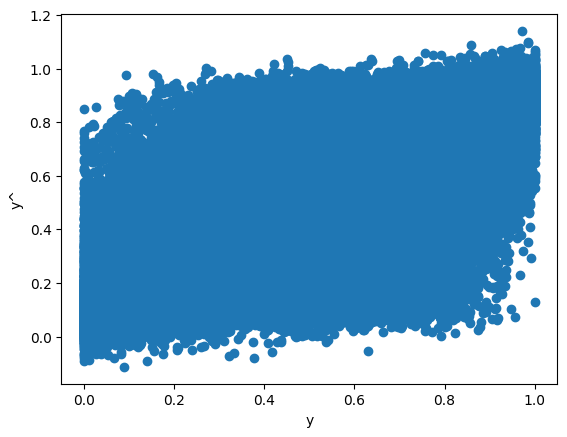

CPU times: user 11.7 s, sys: 13.1 s, total: 24.7 s
Wall time: 12.3 s


{'train': mse_t     0.013317
 rmse_t    0.115398
 mae_t     0.076946
 r2_t      0.805213
 dtype: object,
 'test': mse_t     0.009436
 rmse_t    0.097139
 mae_t     0.063282
 r2_t      0.855637
 mse_v     0.014015
 rmse_v    0.118386
 mae_v     0.079828
 r2_v      0.808378
 dtype: object}

In [59]:
%%time 

test_model_train_val_test(
    lin_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)

# {'train': mse_t     0.013319
#  rmse_t    0.115408
#  mae_t     0.076947
#  r2_t      0.805179
#  dtype: object,
#  'test': mse_t     0.009486
#  rmse_t    0.097396
#  mae_t      0.06385
#  r2_t      0.854869
#  mse_v     0.014026
#  rmse_v    0.118431
#  mae_v     0.079915
#  r2_v      0.808233
#  dtype: object}

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.1s remaining:    3.2s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    2.2s finished



  model test
Scores: [-0.11857087 -0.11858032 -0.11832778 -0.11904488 -0.11836918]
Mean: -0.11857860761817522
Standard deviation: 0.00025465630291614954

Training time: 0.073 s
----- EVALUATION ON VAL SET ------
MSE: 0.014060851384309691
RMSE 0.11857846087848202
MAE: 0.08169020198572707
R^2:  0.7943265403367088



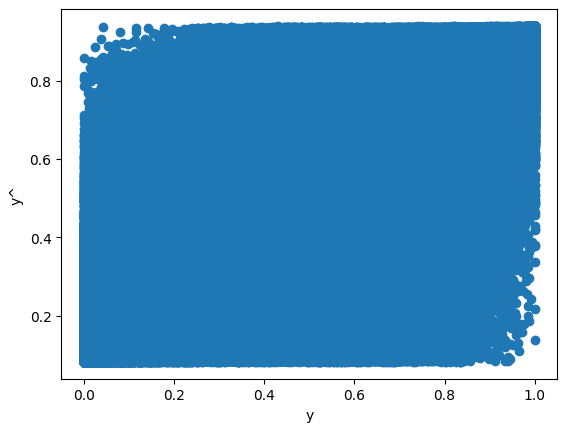


Training time: 0.014 s
----- EVALUATION ON VAL SET ------
MSE: 0.010242818695120375
RMSE 0.1012068115055522
MAE: 0.06831898948036565
R^2:  0.843291675393623



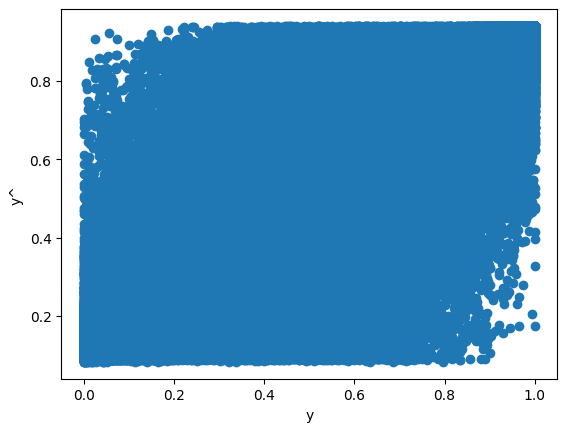


Testing time: 0.009 s
----- EVALUATION ON VAL SET ------
MSE: 0.014813478098552307
RMSE 0.12171063264379291
MAE: 0.08469378976920923
R^2:  0.7974660642148741



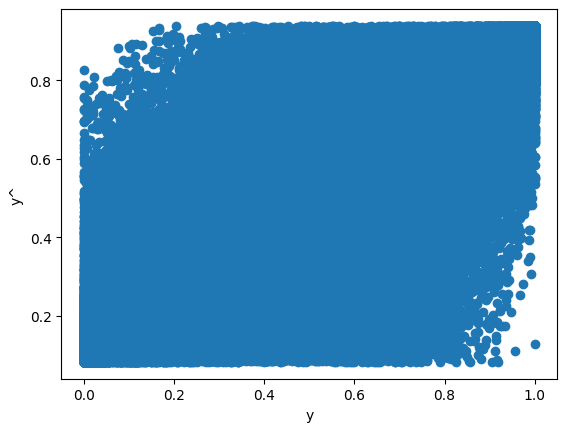

CPU times: user 7.78 s, sys: 4.87 s, total: 12.6 s
Wall time: 7.73 s


{'train': mse_t     0.014061
 rmse_t    0.118578
 mae_t      0.08169
 r2_t      0.794327
 dtype: object,
 'test': mse_t     0.010243
 rmse_t    0.101207
 mae_t     0.068319
 r2_t      0.843292
 mse_v     0.014813
 rmse_v    0.121711
 mae_v     0.084694
 r2_v      0.797466
 dtype: object}

In [60]:
%%time 

test_model_train_val_test(
    lasso_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    1.2s remaining:    1.7s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    1.2s finished



  model test
Scores: [-0.11544144 -0.11536417 -0.11512653 -0.11581943 -0.11524325]
Mean: -0.11539896384218287
Standard deviation: 0.00023591110117132192

Training time: 0.053 s
----- EVALUATION ON VAL SET ------
MSE: 0.01331662411859906
RMSE 0.11539767813348352
MAE: 0.07694604096297653
R^2:  0.8052126376526411



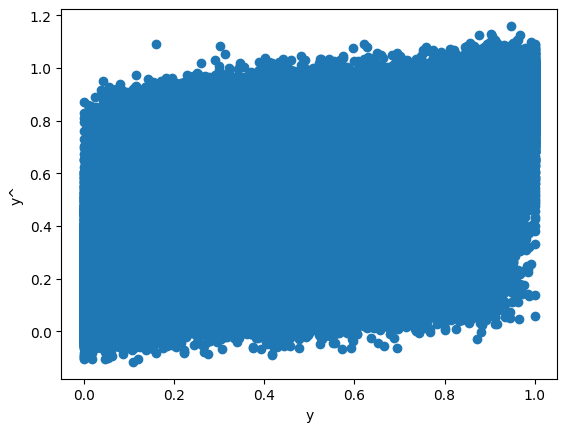


Training time: 0.017 s
----- EVALUATION ON VAL SET ------
MSE: 0.009435907530685034
RMSE 0.0971385995919492
MAE: 0.06328192230273558
R^2:  0.8556368804049235



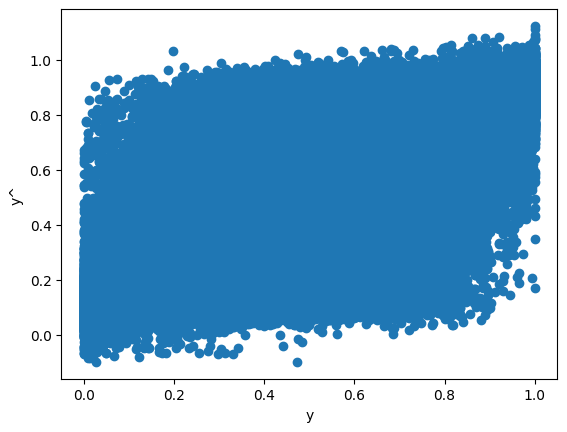


Testing time: 0.009 s
----- EVALUATION ON VAL SET ------
MSE: 0.014015344560368497
RMSE 0.11838642050661256
MAE: 0.07982808243620393
R^2:  0.8083783648707392



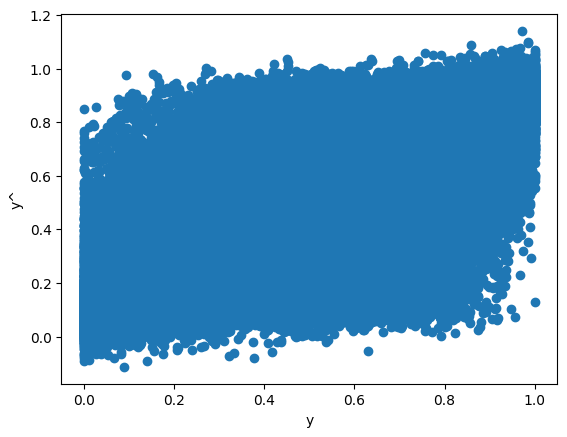

CPU times: user 6.96 s, sys: 4.28 s, total: 11.2 s
Wall time: 6.37 s


{'train': mse_t     0.013317
 rmse_t    0.115398
 mae_t     0.076946
 r2_t      0.805213
 dtype: object,
 'test': mse_t     0.009436
 rmse_t    0.097139
 mae_t     0.063282
 r2_t      0.855637
 mse_v     0.014015
 rmse_v    0.118386
 mae_v     0.079828
 r2_v      0.808378
 dtype: object}

In [61]:
%%time 

test_model_train_val_test(
    ridge_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    5.6s remaining:    8.3s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:    5.7s finished



  model test
Scores: [-0.11720248 -0.11716541 -0.11693837 -0.11768183 -0.11697509]
Mean: -0.1171926354069707
Standard deviation: 0.0002653759007105626

Training time: 0.066 s
----- EVALUATION ON VAL SET ------
MSE: 0.013734045711354559
RMSE 0.11719234493495963
MAE: 0.07925548118130181
R^2:  0.7991068521085319



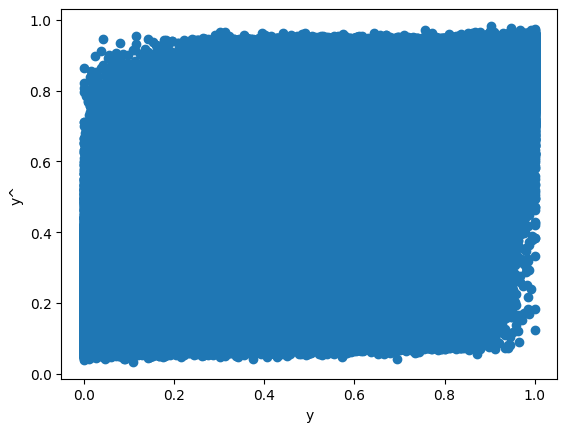


Training time: 0.016 s
----- EVALUATION ON VAL SET ------
MSE: 0.009884143907271629
RMSE 0.0994190319167896
MAE: 0.06560014895517517
R^2:  0.848779161480739



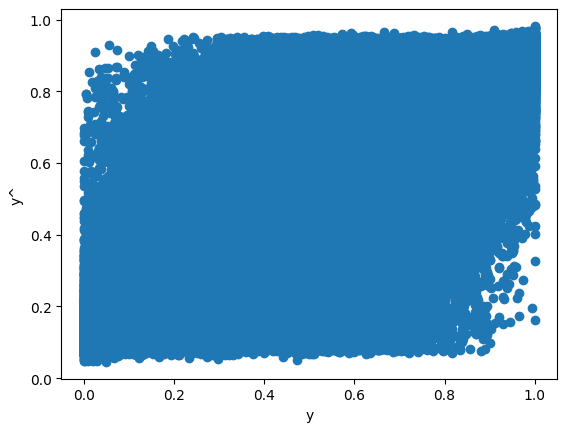


Testing time: 0.009 s
----- EVALUATION ON VAL SET ------
MSE: 0.014459380076284471
RMSE 0.12024716244587424
MAE: 0.08218357273221435
R^2:  0.8023073895016508



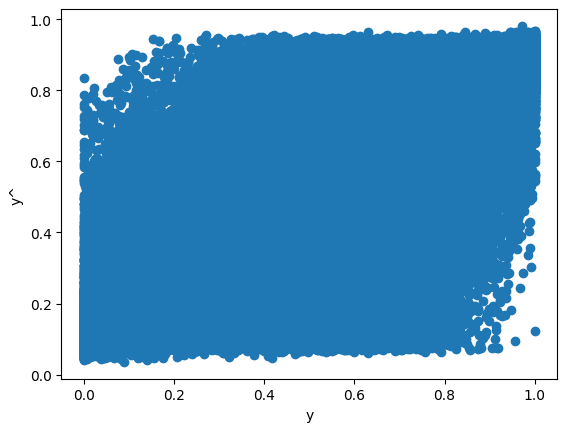

CPU times: user 15.9 s, sys: 7.02 s, total: 22.9 s
Wall time: 11.8 s


{'train': mse_t     0.013734
 rmse_t    0.117192
 mae_t     0.079255
 r2_t      0.799107
 dtype: object,
 'test': mse_t     0.009884
 rmse_t    0.099419
 mae_t       0.0656
 r2_t      0.848779
 mse_v     0.014459
 rmse_v    0.120247
 mae_v     0.082184
 r2_v      0.802307
 dtype: object}

In [64]:
%%time 

test_model_train_val_test(
    elasticNet_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)


## KNN3
### Not ideal to store and sort large data.
https://www.kaggle.com/general/352216

## SVM 
### SVM is not suitable for large datasets because of its high training time and it also takes more time in training compared to Naïve Bayes. 
https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python#advantages

## Decision Tree

In [93]:
from sklearn.tree import DecisionTreeRegressor

In [94]:
%%time 

# define model 
tree_reg = DecisionTreeRegressor(
    criterion='friedman_mse',
    max_depth=11, 
    random_state=config.seed
)


CPU times: user 39 µs, sys: 0 ns, total: 39 µs
Wall time: 42.7 µs


### Train and test, validate model

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   25.7s remaining:   38.5s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   25.9s remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   25.9s finished



  model test
Scores: [-0.11194939 -0.11178012 -0.11159929 -0.11208939 -0.11154204]
Mean: -0.11179204675468628
Standard deviation: 0.00020638024371740887

Training time: 0.233 s
----- EVALUATION ON VAL SET ------
MSE: 0.01218659879151102
RMSE 0.11039292908294
MAE: 0.07305095587783127
R^2:  0.8217419510047962



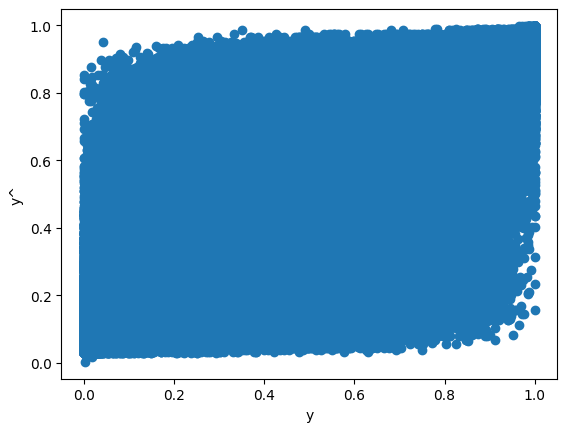


Training time: 0.055 s
----- EVALUATION ON VAL SET ------
MSE: 0.009068271423730095
RMSE 0.09522747200115152
MAE: 0.06069772190164947
R^2:  0.8612614687238758



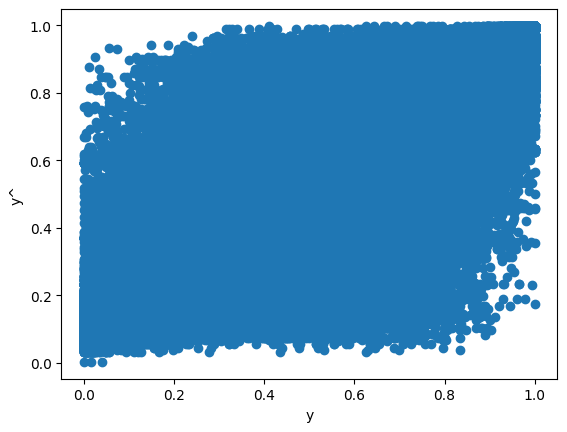


Testing time: 0.036 s
----- EVALUATION ON VAL SET ------
MSE: 0.013119187529428077
RMSE 0.11453902186341595
MAE: 0.0769094263151979
R^2:  0.8206308696066535



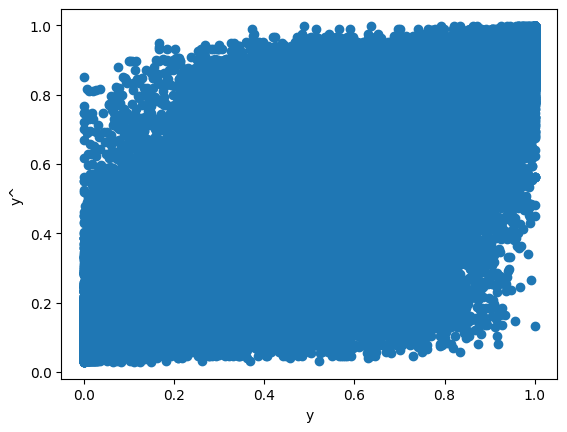

CPU times: user 33.2 s, sys: 508 ms, total: 33.7 s
Wall time: 59 s


{'train': mse_t     0.012187
 rmse_t    0.110393
 mae_t     0.073051
 r2_t      0.821742
 dtype: object,
 'test': mse_t     0.009068
 rmse_t    0.095227
 mae_t     0.060698
 r2_t      0.861261
 mse_v     0.013119
 rmse_v    0.114539
 mae_v     0.076909
 r2_v      0.820631
 dtype: object}

In [95]:
%%time 

test_model_train_val_test(
    tree_reg, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)

# {'train': mse_t     0.012237
#  rmse_t    0.110621
#  mae_t     0.073122
#  r2_t      0.821003
#  dtype: object,
#  'test': mse_t     0.008864
#  rmse_t    0.094151
#  mae_t     0.059995
#  r2_t       0.86438
#  mse_v     0.013122
#  rmse_v     0.11455
#  mae_v      0.07691
#  r2_v      0.820596
#  dtype: object}

### Testing each month

In [117]:
%%time 

result = do_test_per_month(
    DecisionTreeRegressor, dict(criterion='friedman_mse', max_depth=11, random_state=config.seed),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2022],
    months
)

  0%|          | 0/8 [00:00<?, ?months/s]

CPU times: user 26.2 s, sys: 17.8 ms, total: 26.2 s
Wall time: 26.2 s


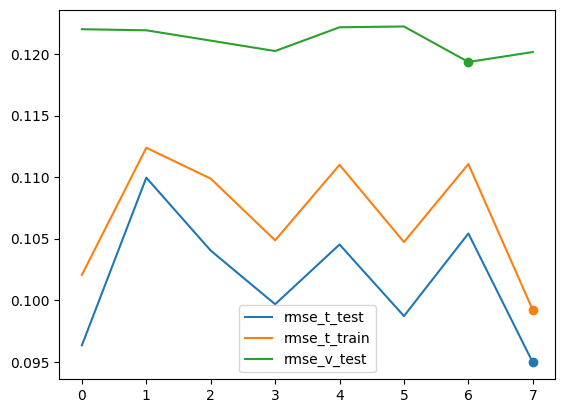

In [118]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

aux=result[result.rmse_t_test == result.rmse_t_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_test'].to_list())

aux=result[result.rmse_t_train == result.rmse_t_train.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_train'].to_list())

aux=result[result.rmse_v_test == result.rmse_v_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_v_test'].to_list())

In [119]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

# rmse_t_test     0.091301
# rmse_t_train     0.09943
# rmse_v_test     0.119586
# dtype: object

rmse_t_test     0.094937
rmse_t_train    0.099202
rmse_v_test     0.119361
dtype: object

In [120]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

# r2_t_test     0.867151
# r2_t_train    0.850738
# r2_v_test     0.804474
# dtype: object

r2_t_test     0.856359
r2_t_train    0.851421
r2_v_test     0.805211
dtype: object

### Testing combination of three consecutive months

In [121]:
%%time 

result = do_test_per_month_combos(
    DecisionTreeRegressor, dict(criterion='friedman_mse', max_depth=11, random_state=config.seed),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2022],
    [[11,12,1], [12,1,2],[1,2,3], [2,3,4], [3,4,5], [2,3], [3,4]]
)

  0%|          | 0/8 [00:00<?, ?months/s]

CPU times: user 1min 6s, sys: 241 ms, total: 1min 7s
Wall time: 1min 7s


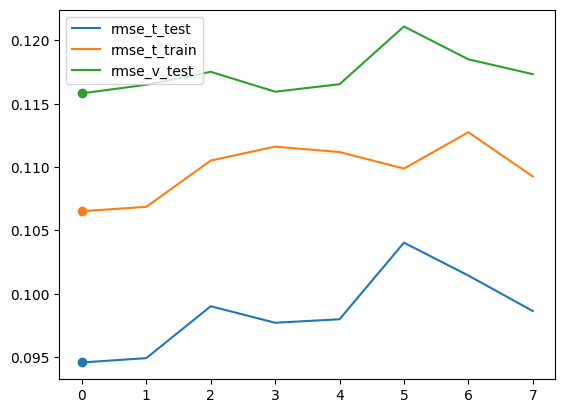

In [122]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

aux=result[result.rmse_t_test == result.rmse_t_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_test'].to_list())

aux=result[result.rmse_t_train == result.rmse_t_train.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_train'].to_list())

aux=result[result.rmse_v_test == result.rmse_v_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_v_test'].to_list())

In [123]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

# rmse_t_test     0.093224
# rmse_t_train    0.106735
# rmse_v_test     0.115668
# dtype: object

rmse_t_test     0.094571
rmse_t_train    0.106515
rmse_v_test     0.115821
dtype: object

In [124]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

# r2_t_test     0.864013
# r2_t_train     0.83079
# r2_v_test     0.817077
# dtype: object

r2_t_test      0.86012
r2_t_train    0.831486
r2_v_test     0.816594
dtype: object

### Fine tuning parameters

In [102]:
# define model 
tree_reg = DecisionTreeRegressor(random_state=config.seed)

param_grid = [
    {
        'max_depth':[9,11,13],
        'criterion':['friedman_mse']
    }
]

grid_search = GridSearchCV(
    tree_reg, param_grid, cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    return_train_score=True,
    error_score='raise'
)

In [103]:
grid_search.fit(X_train_prepared, y_train_prepared)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ................criterion=friedman_mse, max_depth=9; total time=  19.1s
[CV] END ................criterion=friedman_mse, max_depth=9; total time=  18.9s
[CV] END ................criterion=friedman_mse, max_depth=9; total time=  19.0s
[CV] END ................criterion=friedman_mse, max_depth=9; total time=  18.9s
[CV] END ................criterion=friedman_mse, max_depth=9; total time=  18.9s
[CV] END ...............criterion=friedman_mse, max_depth=11; total time=  21.3s
[CV] END ...............criterion=friedman_mse, max_depth=11; total time=  21.4s
[CV] END ...............criterion=friedman_mse, max_depth=11; total time=  21.4s
[CV] END ...............criterion=friedman_mse, max_depth=11; total time=  21.3s
[CV] END ...............criterion=friedman_mse, max_depth=11; total time=  21.3s
[CV] END ...............criterion=friedman_mse, max_depth=13; total time=  24.5s
[CV] END ...............criterion=friedman_mse, m

GridSearchCV(cv=5, error_score='raise',
             estimator=DecisionTreeRegressor(random_state=42),
             param_grid=[{'criterion': ['friedman_mse'],
                          'max_depth': [9, 11, 13]}],
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=2)

In [104]:

print("the best parameters are:")
print(grid_search.best_params_)


the best parameters are:
{'criterion': 'friedman_mse', 'max_depth': 11}


In [105]:
print("the best trained model:")
grid_search.best_estimator_

the best trained model:


DecisionTreeRegressor(criterion='friedman_mse', max_depth=11, random_state=42)

In [106]:
print("Best Score")
-grid_search.best_score_

Best Score


0.11179204675468628

In [107]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(-mean_score, params)

0.11227087693857343 {'criterion': 'friedman_mse', 'max_depth': 9}
0.11179204675468628 {'criterion': 'friedman_mse', 'max_depth': 11}
0.11280163105941832 {'criterion': 'friedman_mse', 'max_depth': 13}


In [108]:
results = grid_search.cv_results_

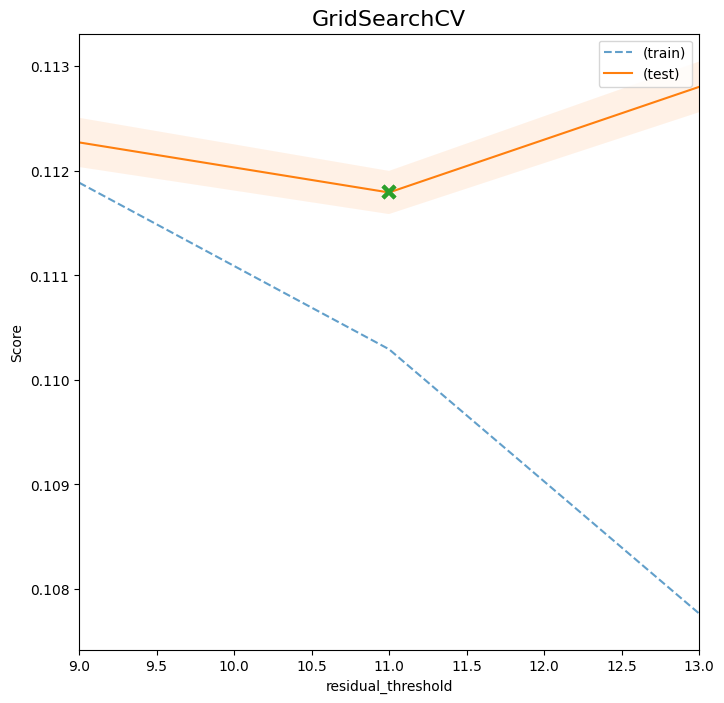

In [109]:
print_grid_result(results, 'param_max_depth')

## Random Forest

In [114]:
from sklearn.ensemble import RandomForestRegressor

In [115]:
%%time 

# define used regressor
forest=RandomForestRegressor(n_estimators=100,
                             max_depth=11,
                             criterion='friedman_mse',
                             n_jobs=10,
                             random_state=config.seed
                            )

CPU times: user 39 µs, sys: 55 µs, total: 94 µs
Wall time: 101 µs


### Train and test, validate model

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.


[CV] END .................................................... total time=  23.4s
[CV] END .................................................... total time=15.1min


[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 15.1min remaining: 22.6min


[CV] END .................................................... total time=  24.1s
[CV] END .................................................... total time=15.1min
[CV] END .................................................... total time=  22.9s
[CV] END .................................................... total time=15.1min
[CV] END .................................................... total time=  24.6s
[CV] END .................................................... total time=15.1min


[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 15.1min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 15.1min finished


[CV] END .................................................... total time=  25.4s
[CV] END .................................................... total time=15.1min

  model test
Scores: [-0.11071066 -0.11058316 -0.11031128 -0.1109294  -0.11031194]
Mean: -0.110569289851885
Standard deviation: 0.00023776334519980152

Training time: 1.988 s
----- EVALUATION ON VAL SET ------
MSE: 0.011970037847413184
RMSE 0.1094076681380843
MAE: 0.07231405804122679
R^2:  0.824909670894806



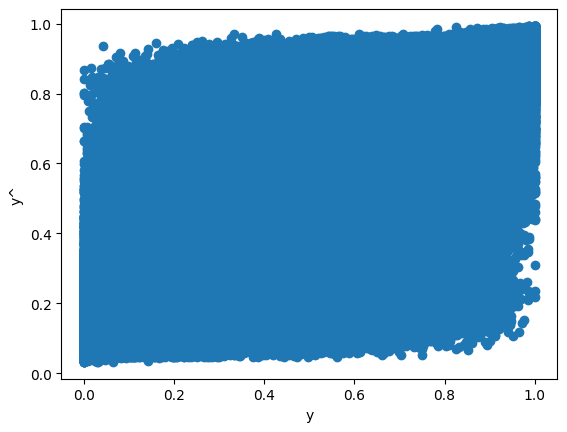


Training time: 0.471 s
----- EVALUATION ON VAL SET ------
MSE: 0.008741700409221164
RMSE 0.09349706096568577
MAE: 0.05970066714230856
R^2:  0.8662577883964167



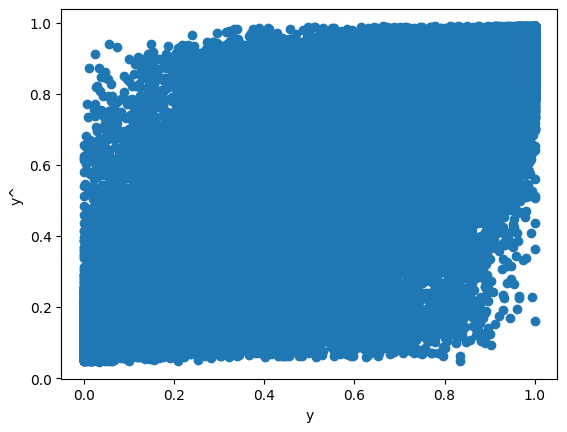


Testing time: 0.3 s
----- EVALUATION ON VAL SET ------
MSE: 0.012847663022507918
RMSE 0.11334753205300907
MAE: 0.07610767796090133
R^2:  0.8243432271423243



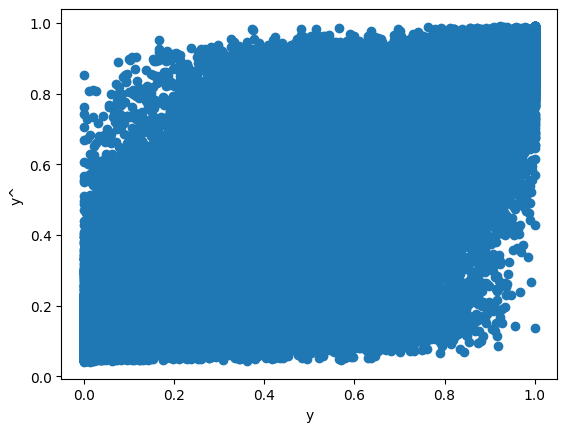

CPU times: user 40min 41s, sys: 1.18 s, total: 40min 42s
Wall time: 19min 19s


{'train': mse_t      0.01197
 rmse_t    0.109408
 mae_t     0.072314
 r2_t       0.82491
 dtype: object,
 'test': mse_t     0.008742
 rmse_t    0.093497
 mae_t     0.059701
 r2_t      0.866258
 mse_v     0.012848
 rmse_v    0.113348
 mae_v     0.076108
 r2_v      0.824343
 dtype: object}

In [116]:
%%time

test_model_train_val_test(
    forest, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)

### Testing each month

### Testing combination of three consecutive months

## Gaussian Process

## Gradiend Boosting

In [125]:
from sklearn.ensemble import GradientBoostingRegressor

In [126]:
%%time 

boosting = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=11, 
    loss='squared_error',
    criterion='friedman_mse',
    random_state=config.seed,
    verbose=2,
    warm_start=True
)


CPU times: user 27 µs, sys: 36 µs, total: 63 µs
Wall time: 68.7 µs


### Train and test, validate model

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed: 49.7min remaining: 74.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 49.8min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed: 49.8min finished



  model test
Scores: [-0.10554523 -0.10525973 -0.10517067 -0.10552682 -0.10505154]
Mean: -0.10531079402915659
Standard deviation: 0.00019549038284413304
      Iter       Train Loss   Remaining Time 
         1           0.0577           49.61m
         2           0.0490           49.06m
         3           0.0420           48.52m
         4           0.0363           47.97m
         5           0.0317           47.46m
         6           0.0280           46.96m
         7           0.0249           46.48m
         8           0.0224           45.99m
         9           0.0204           45.51m
      Iter       Train Loss   Remaining Time 
         1           0.0577           46.65m
         2           0.0491           46.81m
         3           0.0421           46.10m
         4           0.0363           45.47m
         5           0.0317           44.78m
         6           0.0280           44.29m
         7           0.0249           43.78m
         8           0.0224       

      Iter       Train Loss   Remaining Time 
         1           0.0576           47.51m
         2           0.0490           47.67m
         3           0.0419           46.70m
         4           0.0363           46.06m
         5           0.0316           45.46m
         6           0.0279           44.91m
         7           0.0249           44.29m
         8           0.0224           43.73m
         9           0.0204           43.15m
        10           0.0187           42.59m
        11           0.0174           42.04m
        12           0.0163           41.51m
        13           0.0154           41.00m
        14           0.0147           40.50m
        15           0.0141           40.00m
        16           0.0136           39.52m
        17           0.0132           39.03m
        18           0.0128           38.55m
        19           0.0125           38.08m
        20           0.0123           37.61m
        21           0.0121           37.14m
        2

      Iter       Train Loss   Remaining Time 
         1           0.0576           46.42m
         2           0.0490           46.62m
         3           0.0420           46.34m
         4           0.0363           45.93m
         5           0.0317           45.56m
         6           0.0279           45.20m
         7           0.0249           44.88m
         8           0.0224           44.49m
         9           0.0204           44.06m
        10           0.0187           43.45m
        11           0.0174           42.84m
        12           0.0163           42.26m
        13           0.0154           41.70m
        14           0.0147           41.17m
        15           0.0141           40.64m
        16           0.0136           40.12m
        17           0.0132           39.60m
        18           0.0128           39.10m
        19           0.0126           38.61m
        20           0.0123           38.12m
        21           0.0121           37.65m
        2

        90           0.0098            5.29m
        91           0.0098            4.76m
        92           0.0098            4.24m
        93           0.0097            3.71m
        94           0.0097            3.18m
        95           0.0097            2.65m
        96           0.0097            2.12m
        97           0.0097            1.59m
        98           0.0097            1.06m
        99           0.0097           31.85s
       100           0.0097            0.00s

Training time: 10.403 s
----- EVALUATION ON VAL SET ------
MSE: 0.009664163985422114
RMSE 0.09830647987504239
MAE: 0.06565773071036231
R^2:  0.8586385712138916



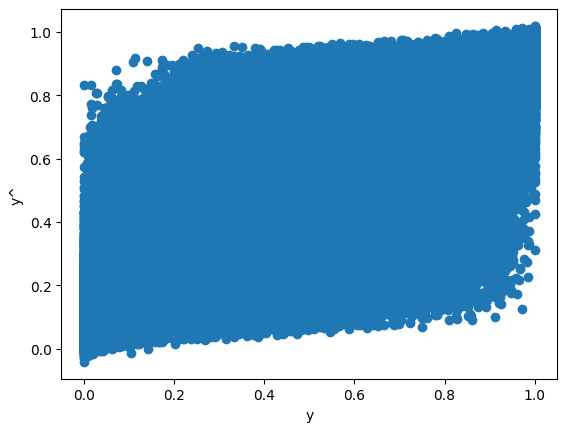


Training time: 2.367 s
----- EVALUATION ON VAL SET ------
MSE: 0.009713917625107654
RMSE 0.09855920872809223
MAE: 0.06703893344288613
R^2:  0.8513835105643166



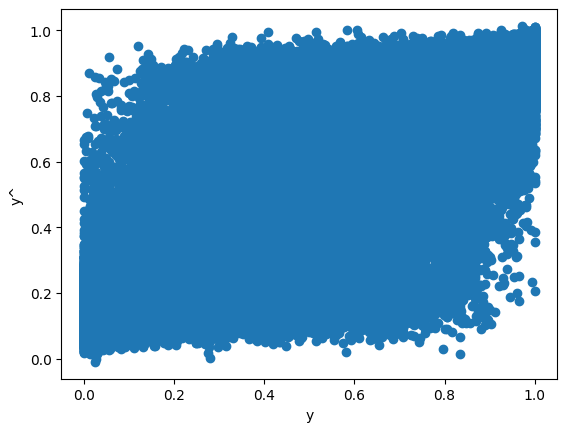


Testing time: 1.51 s
----- EVALUATION ON VAL SET ------
MSE: 0.012109677914143788
RMSE 0.11004398172614342
MAE: 0.07520329746662556
R^2:  0.8344331619674488



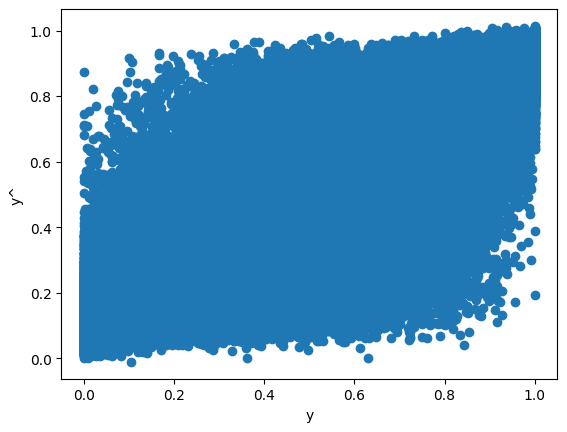

CPU times: user 53min 25s, sys: 2.19 s, total: 53min 28s
Wall time: 1h 43min 14s


{'train': mse_t     0.009664
 rmse_t    0.098306
 mae_t     0.065658
 r2_t      0.858639
 dtype: object,
 'test': mse_t     0.009714
 rmse_t    0.098559
 mae_t     0.067039
 r2_t      0.851384
 mse_v      0.01211
 rmse_v    0.110044
 mae_v     0.075203
 r2_v      0.834433
 dtype: object}

In [127]:
%%time 

test_model_train_val_test(
    boosting, 
    (X_train_prepared, y_train_prepared),
    (X_val_prepared, y_val_prepared),
    (X_test_prepared,  y_test_prepared),
    show=True
)

### Testing each month

In [128]:
%%time 

result = do_test_per_month(
    GradientBoostingRegressor, 
    dict(
        n_estimators=100,
        max_depth=11, 
        loss='squared_error',
        criterion='friedman_mse',
        random_state=config.seed,
        verbose=0
    ),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2022],
    months
)

# CPU times: user 38min 55s, sys: 196 ms, total: 38min 55s
# Wall time: 38min 54s

  0%|          | 0/8 [00:00<?, ?months/s]

CPU times: user 40min 58s, sys: 204 ms, total: 40min 58s
Wall time: 40min 58s


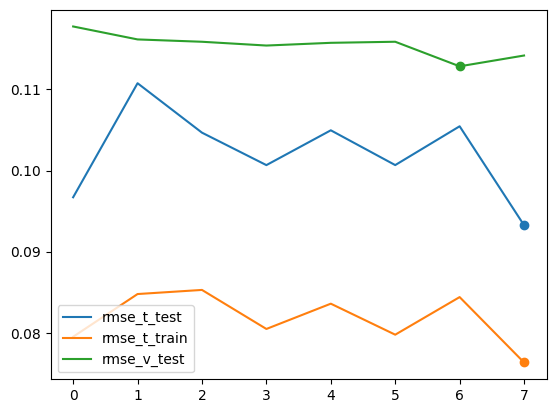

In [129]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

aux=result[result.rmse_t_test == result.rmse_t_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_test'].to_list())

aux=result[result.rmse_t_train == result.rmse_t_train.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_train'].to_list())

aux=result[result.rmse_v_test == result.rmse_v_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_v_test'].to_list())

In [130]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

rmse_t_test     0.093255
rmse_t_train    0.076329
rmse_v_test      0.11285
dtype: object

In [131]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

r2_t_test     0.861402
r2_t_train    0.912037
r2_v_test     0.825883
dtype: object

### Testing combination of three consecutive months

In [132]:
%%time 

result = do_test_per_month_combos(
    GradientBoostingRegressor, 
    dict(
        n_estimators=100,
        max_depth=11, 
        loss='squared_error',
        criterion='friedman_mse',
        random_state=config.seed,
        verbose=2
    ),
    (X_train, y_train),
    (X_val, y_val),
    (X_test,  y_test),
    [2022],
    [[11,12,1], [12,1,2],[1,2,3], [2,3,4], [3,4,5], [2,3], [3,4]]
)

  0%|          | 0/8 [00:00<?, ?months/s]

      Iter       Train Loss   Remaining Time 
         1           0.0567           15.94m
         2           0.0481           15.77m
         3           0.0411           15.61m
         4           0.0354           15.44m
         5           0.0308           15.27m
         6           0.0270           15.12m
         7           0.0240           14.97m
         8           0.0215           14.81m
         9           0.0195           14.65m
        10           0.0178           14.49m
        11           0.0165           14.33m
        12           0.0154           14.17m
        13           0.0145           14.01m
        14           0.0137           13.85m
        15           0.0131           13.69m
        16           0.0126           13.53m
        17           0.0122           13.38m
        18           0.0118           13.21m
        19           0.0115           13.06m
        20           0.0113           12.90m
        21           0.0111           12.74m
        2

        82           0.0085            3.03m
        83           0.0085            2.87m
        84           0.0085            2.71m
        85           0.0085            2.54m
        86           0.0085            2.37m
        87           0.0084            2.20m
        88           0.0084            2.04m
        89           0.0084            1.87m
        90           0.0084            1.70m
        91           0.0084            1.53m
        92           0.0084            1.36m
        93           0.0084            1.19m
        94           0.0083            1.02m
        95           0.0083           51.18s
        96           0.0083           40.97s
        97           0.0083           30.78s
        98           0.0083           20.53s
        99           0.0083           10.26s
       100           0.0083            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0555           15.90m
         2           0.0472           15.72m
         

        63           0.0097            6.13m
        64           0.0096            5.97m
        65           0.0096            5.81m
        66           0.0096            5.65m
        67           0.0096            5.49m
        68           0.0095            5.34m
        69           0.0095            5.18m
        70           0.0095            5.01m
        71           0.0095            4.86m
        72           0.0095            4.70m
        73           0.0094            4.53m
        74           0.0094            4.37m
        75           0.0094            4.21m
        76           0.0094            4.04m
        77           0.0093            3.88m
        78           0.0093            3.71m
        79           0.0093            3.55m
        80           0.0093            3.38m
        81           0.0093            3.21m
        82           0.0092            3.05m
        83           0.0092            2.88m
        84           0.0092            2.71m
        85

        44           0.0087            2.85m
        45           0.0086            2.80m
        46           0.0086            2.75m
        47           0.0085            2.70m
        48           0.0085            2.65m
        49           0.0084            2.60m
        50           0.0084            2.56m
        51           0.0084            2.51m
        52           0.0083            2.45m
        53           0.0083            2.41m
        54           0.0082            2.36m
        55           0.0082            2.31m
        56           0.0082            2.26m
        57           0.0081            2.21m
        58           0.0081            2.16m
        59           0.0081            2.11m
        60           0.0081            2.06m
        61           0.0080            2.01m
        62           0.0080            1.96m
        63           0.0080            1.91m
        64           0.0080            1.86m
        65           0.0080            1.81m
        66

        25           0.0108            7.92m
        26           0.0106            7.82m
        27           0.0105            7.71m
        28           0.0104            7.61m
        29           0.0104            7.51m
        30           0.0103            7.41m
        31           0.0102            7.30m
        32           0.0101            7.20m
        33           0.0101            7.10m
        34           0.0100            6.99m
        35           0.0100            6.89m
        36           0.0099            6.78m
        37           0.0099            6.68m
        38           0.0098            6.58m
        39           0.0098            6.47m
        40           0.0097            6.37m
        41           0.0097            6.27m
        42           0.0096            6.17m
        43           0.0095            6.06m
        44           0.0095            5.96m
        45           0.0094            5.86m
        46           0.0094            5.76m
        47

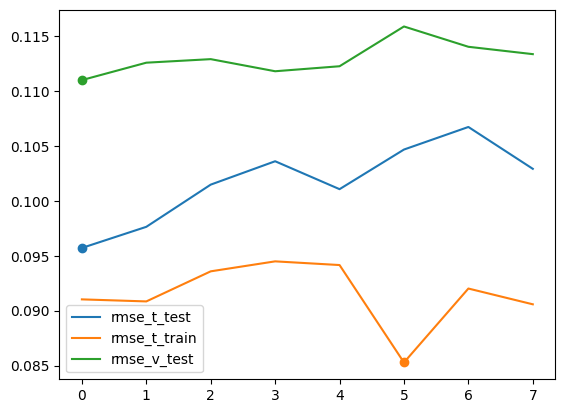

In [133]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].plot()

aux=result[result.rmse_t_test == result.rmse_t_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_test'].to_list())

aux=result[result.rmse_t_train == result.rmse_t_train.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_t_train'].to_list())

aux=result[result.rmse_v_test == result.rmse_v_test.min()]
plt.scatter(aux.order_.to_list(), aux['rmse_v_test'].to_list())

In [134]:
result[['rmse_t_test','rmse_t_train','rmse_v_test']].min()

rmse_t_test     0.095706
rmse_t_train    0.085275
rmse_v_test     0.110994
dtype: object

In [135]:
result[['r2_t_test','r2_t_train','r2_v_test']].max()

r2_t_test     0.856744
r2_t_train    0.888147
r2_v_test     0.831563
dtype: object

## HistGradientBoostingRegressor

# Generate Sample

In [178]:
sample_data = pd.read_csv('dades/processed/kaggle_sample_data.csv')

In [179]:
sample_data

,index,station_id,month,day,hour,ctx4,ctx3,ctx2,ctx1,year,dayofweek,dayofyear,festius,festius_sun,festius_sun_sat,weekend,VALOR_TM_D5,VALOR_TX_D5,VALOR_TN_D5,VALOR_HRM_D5,VALOR_PPT_D5,VALOR_PM_D5,VALOR_RS24h_D5,VALOR_VVM10_D5,VALOR_DVM10_D5,VALOR_VVX10_D5,VALOR_DVVX10_D5,VALOR_HRX_D5,VALOR_HRN_D5,VALOR_PX_D5,VALOR_PN_D5,VALOR_TM_X2,VALOR_TX_X2,VALOR_TN_X2,VALOR_HRM_X2,VALOR_HRX_X2,VALOR_HRN_X2,VALOR_TM_X4,VALOR_TX_X4,VALOR_TN_X4,VALOR_HRM_X4,VALOR_PPT_X4,VALOR_PM_X4,VALOR_RS24h_X4,VALOR_VVM10_X4,VALOR_DVM10_X4,VALOR_VVX10_X4,VALOR_DVVX10_X4,VALOR_HRX_X4,VALOR_HRN_X4,VALOR_PX_X4,VALOR_PN_X4,VALOR_TM_X8,VALOR_TX_X8,VALOR_TN_X8,VALOR_HRM_X8,VALOR_PPT_X8,VALOR_PM_X8,VALOR_RS24h_X8,VALOR_VVM10_X8,VALOR_DVM10_X8,VALOR_VVX10_X8,VALOR_DVVX10_X8,VALOR_HRX_X8,VALOR_HRN_X8,VALOR_PX_X8,VALOR_PN_X8,capacity
0,0,394,3,7,8,0.753086,0.780864,0.799383,0.824074,2023,1,66,0,0,0,0,12.5,18.4,8.0,59.0,0.0,959.4,15.1,3.5,259.0,11.5,262.0,91.0,46.0,961.7,956.7,12.8,20.9,5.8,71.0,93.0,40.0,13.9,20.6,8.7,61.0,0.0,1003.7,15.9,1.5,170.0,10.8,293.0,80.0,39.0,1006.1,1000.6,13.3,20.2,6.5,61.0,0.0,997.9,13.7,1.8,264.0,10.0,262.0,84.0,41.0,1000.2,995.0,27
1,1,337,3,23,12,0.463768,0.536232,0.532609,0.601449,2023,3,82,0,0,1,0,13.1,19.3,10.5,81.0,0.0,967.0,20.1,4.4,239.0,8.5,214.0,100.0,56.0,968.0,966.0,15.1,19.3,12.4,79.0,90.0,63.0,15.2,18.7,13.4,78.0,0.0,1011.6,18.2,2.1,241.0,8.2,221.0,92.0,60.0,1012.5,1010.6,14.2,19.0,11.1,84.0,0.0,1005.8,18.1,2.0,245.0,7.8,214.0,99.0,62.0,1006.7,1004.9,24
2,2,368,3,31,1,0.787037,0.709877,0.611111,0.601852,2023,4,90,0,0,0,0,16.6,24.4,11.4,61.0,0.0,967.8,17.3,3.9,249.0,11.3,247.0,93.0,29.0,969.5,965.6,16.5,26.2,13.2,72.0,90.0,26.0,16.7,25.4,13.2,70.0,0.0,1011.9,16.8,2.5,28.0,9.7,300.0,96.0,25.0,1014.2,1009.8,17.1,26.3,12.0,67.0,0.0,1006.1,17.4,2.6,66.0,10.1,311.0,100.0,25.0,1008.3,1004.0,28
3,3,327,3,23,15,0.753472,0.809028,0.819444,0.736111,2023,3,82,0,0,1,0,13.1,19.3,10.5,81.0,0.0,967.0,20.1,4.4,239.0,8.5,214.0,100.0,56.0,968.0,966.0,15.1,19.3,12.4,79.0,90.0,63.0,15.2,18.7,13.4,78.0,0.0,1011.6,18.2,2.1,241.0,8.2,221.0,92.0,60.0,1012.5,1010.6,14.2,19.0,11.1,84.0,0.0,1005.8,18.1,2.0,245.0,7.8,214.0,99.0,62.0,1006.7,1004.9,24
4,4,328,3,4,20,0.861111,0.802469,0.814815,0.827160,2023,5,63,0,0,1,1,8.2,15.5,3.8,61.0,0.0,970.6,17.8,5.5,294.0,12.9,314.0,73.0,40.0,972.1,969.2,10.0,15.5,5.1,61.0,81.0,37.0,10.9,14.6,7.3,52.0,0.0,1016.0,17.5,1.9,260.0,7.0,227.0,65.0,36.0,1017.6,1014.4,9.6,14.9,5.8,57.0,0.0,1010.1,17.3,2.3,287.0,9.1,291.0,80.0,38.0,1011.5,1008.6,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54994,54994,269,3,14,3,0.478261,0.478261,0.478261,0.478261,2023,1,73,0,0,0,0,13.8,20.7,9.7,50.0,0.0,965.7,19.3,3.4,291.0,14.3,288.0,91.0,26.0,969.3,961.5,16.7,23.2,12.4,49.0,82.0,23.0,17.0,22.2,13.5,44.0,0.0,1010.1,19.5,3.3,345.0,15.6,337.0,73.0,21.0,1014.2,1005.2,16.5,22.3,10.9,42.0,0.0,1004.3,19.5,3.9,321.0,14.0,307.0,83.0,22.0,1008.3,1000.0,28
54995,54995,280,3,1,5,0.098765,0.074074,0.074074,0.077160,2023,2,60,0,0,0,0,5.3,11.5,0.7,48.0,0.0,966.2,17.7,5.9,297.0,13.0,321.0,63.0,30.0,968.1,964.1,7.9,12.6,3.3,43.0,58.0,26.0,8.2,11.4,4.5,38.0,0.0,1011.9,17.6,2.0,284.0,8.5,231.0,49.0,25.0,1013.6,1009.5,7.0,11.8,1.7,41.0,0.0,1006.0,17.5,2.7,265.0,11.4,298.0,57.0,25.0,1007.6,1003.7,27
54996,54996,180,3,20,16,0.782680,0.821895,0.812092,0.777778,2023,0,79,0,0,0,0,12.5,18.2,9.2,77.0,0.0,972.2,20.2,2.9,138.0,9.3,285.0,99.0,38.0,974.2,971.0,14.2,18.5,10.2,76.0,90.0,48.0,14.4,17.2,12.0,72.0,0.0,1017.2,19.9,1.7,130.0,6.6,106.0,87.0,43.0,1019.4,1015.8,14.1,19.3,9.6,70.0,0.0,1011.2,19.0,2.0,180.0,6.6,138.0,94.0,35.0,1013.5,1010.0,51
54997,54997,277,3,14,11,0.774691,0.953704,0.972222,0.472222,2023,1,73,0,0,0,0,13.8,20.7,9.7,50.0,0.0,965.7,19.3,3.4,291.0,14.3,288.0,91.0,26.0,969.3,961.5,16.7,23.2,12.4,49.0,82.0,23.0,17.0,22

## apply pipeline

In [183]:
X_sample_prepared = full_pipeline.transform(sample_data)

print("x_train_prepared:",X_train_prepared.shape,"y_train: ",y_train_prepared.shape)
print("x_test_prepared:",X_val_prepared.shape,"y_test: ",y_val_prepared.shape)
print("x_test_prepared:",X_test_prepared.shape,"y_test: ",y_test_prepared.shape)
print("x_test_prepared:",X_sample_prepared.shape)

x_train_prepared: (2357330, 23) y_train:  (2357330,)
x_test_prepared: (586724, 23) y_test:  (586724,)
x_test_prepared: (359126, 23) y_test:  (359126,)
x_test_prepared: (54999, 23)


## Prediction 

In [184]:
%%time 

model = forest

CPU times: user 4 µs, sys: 4 µs, total: 8 µs
Wall time: 12.6 µs


In [185]:
name = f'{model.__class__}'.split('.')[-1]
name = name.translate( { ord(i): None for i in "'<>"})
number = 1

In [186]:
name

'RandomForestRegressor'

In [187]:
yhat = model.predict(X_sample_prepared)

In [188]:
yhat.shape

(54999,)

In [189]:
sample_data['percentage_docks_available'] = yhat

In [190]:
sample_data['percentage_docks_available'].to_csv(f'{name}{number}.csv', header=True, index_label='index')

In [191]:

aux = X_test[X_test.month.isin([3]) & X_test.station_id.isin(sample_data.station_id.unique())][['station_id', 'year', 'month','day','hour', 'ctx0', 'ctx1', 'ctx2', 'ctx3', 'ctx4']]


In [192]:
sample_data = sample_data.merge(aux,
                                on=['station_id','month','day','hour'],
                                how='left')

In [193]:
sample_data

,index,station_id,month,day,hour,ctx4_x,ctx3_x,ctx2_x,ctx1_x,year_x,dayofweek,dayofyear,festius,festius_sun,festius_sun_sat,weekend,VALOR_TM_D5,VALOR_TX_D5,VALOR_TN_D5,VALOR_HRM_D5,VALOR_PPT_D5,VALOR_PM_D5,VALOR_RS24h_D5,VALOR_VVM10_D5,VALOR_DVM10_D5,VALOR_VVX10_D5,VALOR_DVVX10_D5,VALOR_HRX_D5,VALOR_HRN_D5,VALOR_PX_D5,VALOR_PN_D5,VALOR_TM_X2,VALOR_TX_X2,VALOR_TN_X2,VALOR_HRM_X2,VALOR_HRX_X2,VALOR_HRN_X2,VALOR_TM_X4,VALOR_TX_X4,VALOR_TN_X4,VALOR_HRM_X4,VALOR_PPT_X4,VALOR_PM_X4,VALOR_RS24h_X4,VALOR_VVM10_X4,VALOR_DVM10_X4,VALOR_VVX10_X4,VALOR_DVVX10_X4,VALOR_HRX_X4,VALOR_HRN_X4,VALOR_PX_X4,VALOR_PN_X4,VALOR_TM_X8,VALOR_TX_X8,VALOR_TN_X8,VALOR_HRM_X8,VALOR_PPT_X8,VALOR_PM_X8,VALOR_RS24h_X8,VALOR_VVM10_X8,VALOR_DVM10_X8,VALOR_VVX10_X8,VALOR_DVVX10_X8,VALOR_HRX_X8,VALOR_HRN_X8,VALOR_PX_X8,VALOR_PN_X8,capacity,ctx1_ctx2_mean,ctx1_ctx2_std,ctx1_ctx2_ctx3_mean,ctx1_ctx2_ctx3_std,ctx1_ctx2_ctx3_ctx4_mean,ctx1_ctx2_ctx3_ctx4_std,percentage_docks_available,year_y,ctx0,ctx1_y,ctx2_y,ctx3_y,ctx4_y
0,0,394,3,7,8,0.753086,0.780864,0.799383,0.824074,2023,1,66,0,0,0,0,12.5,18.4,8.0,59.0,0.0,959.4,15.1,3.5,259.0,11.5,262.0,91.0,46.0,961.7,956.7,12.8,20.9,5.8,71.0,93.0,40.0,13.9,20.6,8.7,61.0,0.0,1003.7,15.9,1.5,170.0,10.8,293.0,80.0,39.0,1006.1,1000.6,13.3,20.2,6.5,61.0,0.0,997.9,13.7,1.8,264.0,10.0,262.0,84.0,41.0,1000.2,995.0,27,0.811728,0.017459,0.801440,2.167830e-02,0.789352,0.029964,0.810461,2023,0.693603,0.820513,0.802469,0.777778,0.753086
1,1,337,3,23,12,0.463768,0.536232,0.532609,0.601449,2023,3,82,0,0,1,0,13.1,19.3,10.5,81.0,0.0,967.0,20.1,4.4,239.0,8.5,214.0,100.0,56.0,968.0,966.0,15.1,19.3,12.4,79.0,90.0,63.0,15.2,18.7,13.4,78.0,0.0,1011.6,18.2,2.1,241.0,8.2,221.0,92.0,60.0,1012.5,1010.6,14.2,19.0,11.1,84.0,0.0,1005.8,18.1,2.0,245.0,7.8,214.0,99.0,62.0,1006.7,1004.9,24,0.567029,0.048678,0.556763,3.874158e-02,0.533514,0.056237,0.634232,2023,0.673913,0.619565,0.539130,0.530435,0.456522
2,2,368,3,31,1,0.787037,0.709877,0.611111,0.601852,2023,4,90,0,0,0,0,16.6,24.4,11.4,61.0,0.0,967.8,17.3,3.9,249.0,11.3,247.0,93.0,29.0,969.5,965.6,16.5,26.2,13.2,72.0,90.0,26.0,16.7,25.4,13.2,70.0,0.0,1011.9,16.8,2.5,28.0,9.7,300.0,96.0,25.0,1014.2,1009.8,17.1,26.3,12.0,67.0,0.0,1006.1,17.4,2.6,66.0,10.1,311.0,100.0,25.0,1008.3,1004.0,28,0.606481,0.006547,0.640947,5.987442e-02,0.677469,0.087895,0.593532,2023,0.562963,0.601852,0.600823,0.709877,0.787037
3,3,327,3,23,15,0.753472,0.809028,0.819444,0.736111,2023,3,82,0,0,1,0,13.1,19.3,10.5,81.0,0.0,967.0,20.1,4.4,239.0,8.5,214.0,100.0,56.0,968.0,966.0,15.1,19.3,12.4,79.0,90.0,63.0,15.2,18.7,13.4,78.0,0.0,1011.6,18.2,2.1,241.0,8.2,221.0,92.0,60.0,1012.5,1010.6,14.2,19.0,11.1,84.0,0.0,1005.8,18.1,2.0,245.0,7.8,214.0,99.0,62.0,1006.7,1004.9,24,0.777778,0.058926,0.788194,4.540520e-02,0.779514,0.040937,0.709003,2023,0.883333,0.722222,0.802083,0.812500,0.760417
4,4,328,3,4,20,0.861111,0.802469,0.814815,0.827160,2023,5,63,0,0,1,1,8.2,15.5,3.8,61.0,0.0,970.6,17.8,5.5,294.0,12.9,314.0,73.0,40.0,972.1,969.2,10.0,15.5,5.1,61.0,81.0,37.0,10.9,14.6,7.3,52.0,0.0,1016.0,17.5,1.9,260.0,7.0,227.0,65.0,36.0,1017.6,1014.4,9.6,14.9,5.8,57.0,0.0,1010.1,17.3,2.3,287.0,9.1,291.0,80.0,38.0,1011.5,1008.6,27,0.820988,0.008730,0.814815,1.234568e-02,0.826389,0.025248,0.826353,2023,0.759259,0.827160,0.814815,0.802469,0.861111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54994,54994,269,3,14,3,0.478261,0.478261,0.478261,0.478261,2023,1,73,0,0,0,0,13.8,20.7,9.7,50.0,0.0,965.7,19.3,3.4,291.0,14.3,288.0,91.0,26.0,969.3,961.5,16.7,23.2,12.4,49.0,82.0,23.0,17.0,22.2,13.5,44.0,0.0,1010.1,19.5,3.3,345.0,15.6,337.0,73.0,21.0,1014.2,1005.2,16.5,22.3,10.9,42.0,0.0,1004.3,19.5,3.9,321.0,14.0,307.0,83.0,22.0,1008.3,1000.0,28,0.478261,0.000000,0.478261,6.798700e-17,0.47826

In [194]:

sample_data[['station_id', 'month', 'day', 'hour', 'percentage_docks_available', 'ctx0', 'ctx1_x', 'ctx1_y', 'ctx4_x', 'ctx4_y', 'ctx3_x', 'ctx3_y', 'ctx2_x', 'ctx2_y']]



,station_id,month,day,hour,percentage_docks_available,ctx0,ctx1_x,ctx1_y,ctx4_x,ctx4_y,ctx3_x,ctx3_y,ctx2_x,ctx2_y
0,394,3,7,8,0.810461,0.693603,0.824074,0.820513,0.753086,0.753086,0.780864,0.777778,0.799383,0.802469
1,337,3,23,12,0.634232,0.673913,0.601449,0.619565,0.463768,0.456522,0.536232,0.530435,0.532609,0.539130
2,368,3,31,1,0.593532,0.562963,0.601852,0.601852,0.787037,0.787037,0.709877,0.709877,0.611111,0.600823
3,327,3,23,15,0.709003,0.883333,0.736111,0.722222,0.753472,0.760417,0.809028,0.812500,0.819444,0.802083
4,328,3,4,20,0.826353,0.759259,0.827160,0.827160,0.861111,0.861111,0.802469,0.802469,0.814815,0.814815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54994,269,3,14,3,0.477653,0.478261,0.478261,0.478261,0.478261,0.478261,0.478261,0.478261,0.478261,0.478261
54995,280,3,1,5,0.142113,0.067901,0.077160,0.077160,0.098765,0.098765,0.074074,0.074074,0.074074,0.074074
54996,180,3,20,16,0.758296,0.820728,0.777778,0.780392,0.782680,0.777778,0.821895,0.852941,0.812092,0.810458
54997,277,3,14,11,0.509665,0.722222,0.472222,0.451852,0.774691,0.703704,0.953704,0.958333,0.972222,0.990741


<Axes: >

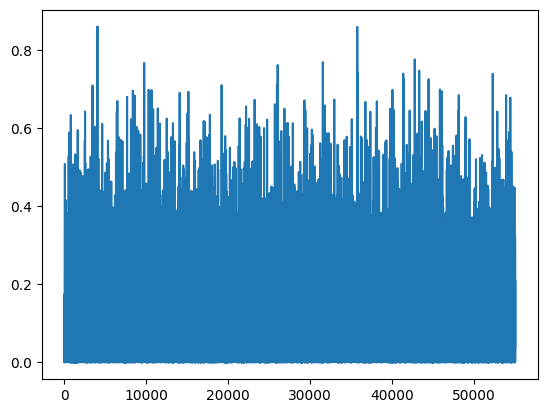

In [195]:
np.abs(sample_data['percentage_docks_available'] - sample_data['ctx0']).plot()